# Indodax Technical Test

## Albiyan Abdika
### +62 89609259585
### abdikaalbiyan@gmail.com

## Tasks:

Build a graph/chart analysis based on the details below:

    1.All data needed for this assignment can be found using Indodax Public API through links below

    2.Calculate the changes in prices of Cryptocurrency within the last 24 hours, please indicate using percentage (results can be positive or negative)

    3.What is the average trading volume within one day for one of the pair?

    4.Provide a conclusion from your finding 

Be creative in presenting your insights and feel free to use any tools you are familiar with. 


Indodax Public API:  https://github.com/btcid/indodax-official-api-docs/blob/master/Public-RestAPI.md



## Collect Data
#### Import modul

In [1]:
import json  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import warnings
import datetime
import time
import pytz

import psycopg2 as ps
import pandas.io.sql as psql

import statistics
import math

from itertools import tee, islice, chain

warnings.filterwarnings('ignore')

pd.set_option('float_format', '{:f}'.format)

####  Collect Data from PostgreSQL and cleansing the data

In [2]:
db = ps.connect(database="indodax_tech_test",
                    user="postgres",
                    password="",
                    host="127.0.0.1",
                    port="5433")

df = psql.read_sql('SELECT * FROM api', db)

df['date'] = pd.to_datetime(df['date'], unit='s') + pd.Timedelta(hours=7)

df = df[['tid', 'date', 'price', 'amount', 'types']]

data = df.drop_duplicates().set_index(['tid'])

data['time_hour'] = data['date'].apply(lambda t: t.replace(minute=0)).apply(lambda t: t.replace(second=0))
data['price'] = data['price'].astype(float)
data['amount'] = data['amount'].astype(float)
data['trx_value'] = data['price'] * data['amount']

start_date = '2020-05-07 18:00:00'
end_date = '2020-05-08 18:00:00'

mask = (data['date'] > start_date) & (data['date'] <= end_date)

data = data.loc[mask]
data

,date,price,amount,types,time_hour,trx_value
tid,,,,,,
15057426,2020-05-07 18:00:06,139801000.000000,0.004298,buy,2020-05-07 18:00:00,600884.270140
15057438,2020-05-07 18:00:48,139750000.000000,0.592084,sell,2020-05-07 18:00:00,82743687.292500
15057440,2020-05-07 18:01:18,139750000.000000,0.003095,sell,2020-05-07 18:00:00,432555.597500
15057441,2020-05-07 18:01:22,139750000.000000,0.024705,sell,2020-05-07 18:00:00,3452465.055000
15057445,2020-05-07 18:01:39,139801000.000000,0.000344,buy,2020-05-07 18:00:00,48101.330070
...,...,...,...,...,...,...
15073279,2020-05-08 17:59:00,148627000.000000,0.006097,buy,2020-05-08 17:00:00,906201.113050
15073280,2020-05-08 17:59:07,148600000.000000,0.032200,sell,2020-05-08 17:00:00,4784920.000000
15073282,2020-05-08 17:59:22,148601000.000000,0.013419,buy,2020-05-08 17:00:00,1994018.864610


.

## Trading Frequency

#### Buy and Sell Overall

types
buy                     3447
sell                    2448
Name: types, dtype: int64

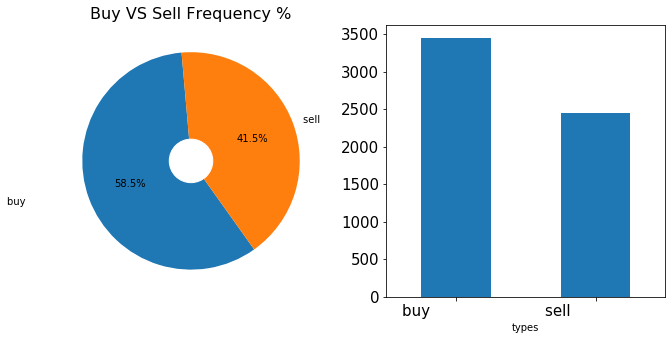

None

In [3]:
sell_vs_buy = data.groupby(['types'])['types'].count()

fig = plt.figure(figsize=[11, 11])
ax = fig.add_subplot(221)
ax.pie(sell_vs_buy, labeldistance=1.1, labels=sell_vs_buy.index, startangle=95, autopct='%1.1f%%')
ax.set_title("Buy VS Sell Frequency %", fontsize=16);
plt.gcf().gca().add_artist(plt.Circle((0,0), 0.2, color='white'))


ax2 = fig.add_subplot(222)
ax2.set_facecolor('white')
sell_vs_buy.plot(kind='bar', ax=ax2, legend=False, fontsize=15, rot=0)

display(sell_vs_buy)
display(plt.show())


.

#### Activity per Hours

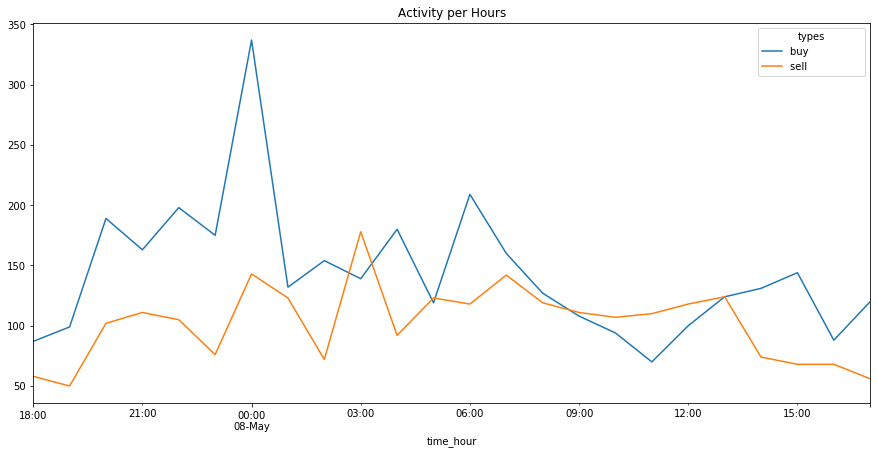

In [4]:
activity_by_hour = data.groupby(['time_hour', 'types'])['time_hour']\
                    .count()\
                    .unstack()\
                    .fillna(0)

activity_by_hour_plot = activity_by_hour.plot(title="Activity per Hours", figsize=(15, 7));
activity_by_hour_plot

.

## Highest, Lowest, and Average Transaction Value every Hours

#### Buy

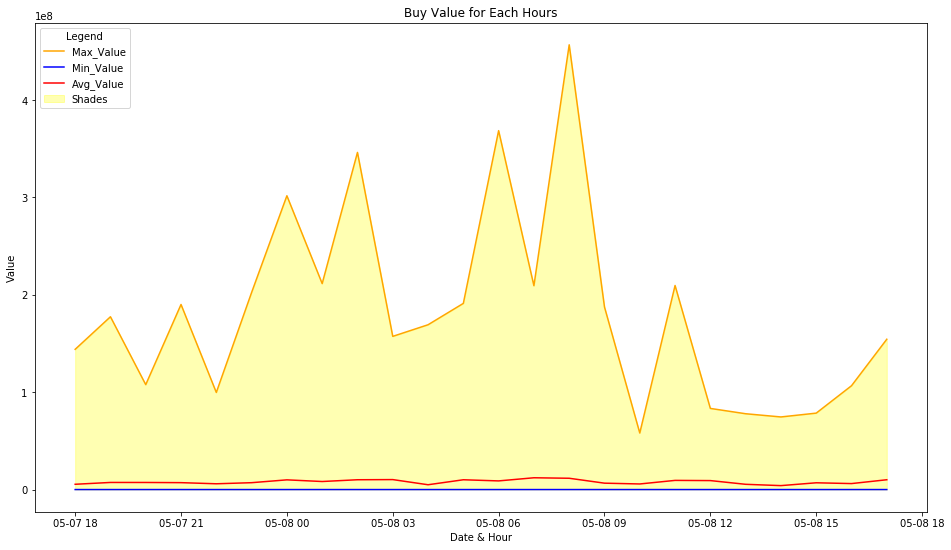

In [5]:
buy_df = data[data['types'].str.contains("buy")]

max_buy_by_hour = buy_df.groupby(['time_hour'])['trx_value'].max()
min_buy_by_hour = buy_df.groupby(['time_hour'])['trx_value'].min()
avg_buy_by_hour = buy_df.groupby(['time_hour'])['trx_value'].mean()

merge_buy = pd.concat([max_buy_by_hour, min_buy_by_hour, avg_buy_by_hour], axis=1)

merge_buy.columns.values[0] = "Max_Value"
merge_buy.columns.values[1] = "Min_Value"
merge_buy.columns.values[2] = "Avg_Value"
                 
plt.rcParams["figure.figsize"] = [16,9]
plt.figure()
plt.xlabel('Date & Hour')
plt.ylabel('Value')

plt.title('Buy Value for Each Hours')

plt.plot(merge_buy.index, merge_buy['Max_Value'], color='orange', label='Max_Value')
plt.plot(merge_buy.index, merge_buy['Min_Value'], color='blue', label='Min_Value')
plt.plot(merge_buy.index, merge_buy['Avg_Value'], color='red', label='Avg_Value')

plt.fill_between(merge_buy.index, merge_buy['Max_Value'], merge_buy['Min_Value'], color='yellow' ,label='Shades', alpha=0.3)
plt.legend(loc='upper left', title='Legend')

plt.show()

#### Sell

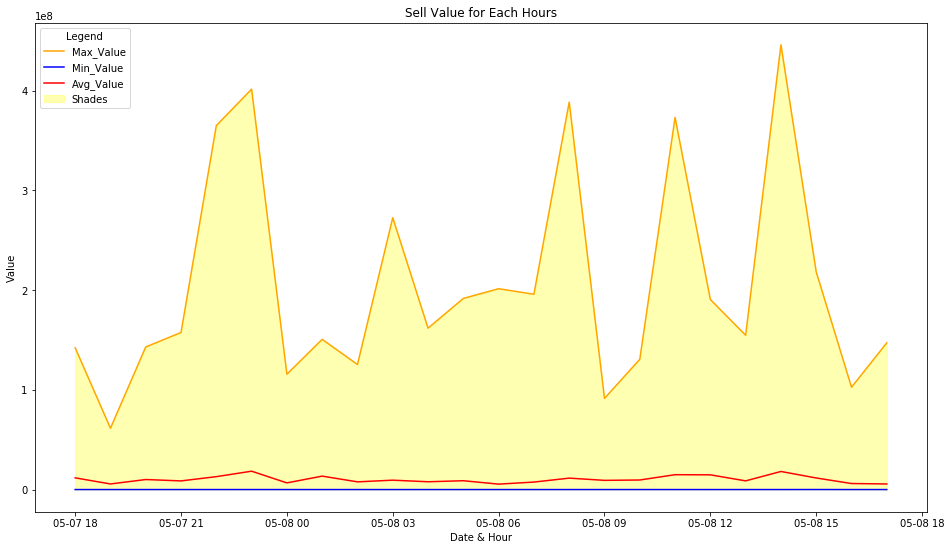

In [6]:
sell_df = data[data['types'].str.contains("sell")]

max_sell_by_hour = sell_df.groupby(['time_hour'])['trx_value'].max()
min_sell_by_hour = sell_df.groupby(['time_hour'])['trx_value'].min()
avg_sell_by_hour = sell_df.groupby(['time_hour'])['trx_value'].mean()

merge_sell = pd.concat([max_sell_by_hour, min_sell_by_hour, avg_sell_by_hour], axis=1)

merge_sell.columns.values[0] = "Max_Value"
merge_sell.columns.values[1] = "Min_Value"
merge_sell.columns.values[2] = "Avg_Value"
                 
plt.rcParams["figure.figsize"] = [16,9]
plt.figure()
plt.xlabel('Date & Hour')
plt.ylabel('Value')

plt.title('Sell Value for Each Hours')

plt.plot(merge_sell.index, merge_sell['Max_Value'], color='orange', label='Max_Value')
plt.plot(merge_sell.index, merge_sell['Min_Value'], color='blue', label='Min_Value')
plt.plot(merge_sell.index, merge_sell['Avg_Value'], color='red', label='Avg_Value')

plt.fill_between(merge_sell.index, merge_sell['Max_Value'], merge_sell['Min_Value'], color='yellow' ,label='Shades', alpha=0.3)
plt.legend(loc='upper left', title='Legend')

plt.show()

In [9]:
def previous_and_next(some_iterable):
    prevs, items, nexts = tee(some_iterable, 3)
    prevs = chain([None], prevs)
    nexts = chain(islice(nexts, 1, None), [None])
    return zip(prevs, items, nexts)


def price_increase_in_percentage(list_of_price):

    changes = []
    for previous, item, nxt in previous_and_next(list_of_price):
        if previous == None:
            previous = item
        change = ((item - previous) / previous) * 100
        if change != 0:
            changes.append(change)

    sum_change = 0
    for i in changes:
        sum_change = sum_change + i

    percentage = sum_change / len(changes)

    return percentage


def average_values(list_of_amount):

    sum_of_list = 0
    for amount in list_of_amount:
        sum_of_list = sum_of_list + amount

    average = sum_of_list / len(list_of_amount)

    return average


# def variance(x):
#     sigma_n = 0
#     for i in x:
#         xi_min_xbar = i - statistics.mean(x)
#         xi_min_xbar_kuadrat = xi_min_xbar**2
#         sigma_n = sigma_n + xi_min_xbar_kuadrat

#     hasil = sigma_n / (len(x) - 1)
#     return hasil


# def stdevs(x):
#     hasil = math.sqrt(variance(x))
#     return hasil


In [10]:
print("__")
print("Percentage of Increase in Selling Price  : ", price_increase_in_percentage(sell_df['price'].to_list()), "%")
print("Percentage of Increase in Purchase Price : ", price_increase_in_percentage(buy_df['price'].to_list()), "%")

print("___________________________")
print("Average Trading Volume                   : ", average_values(data['amount'].to_list()))
print("Average Trading Volume(Buy)              : ", average_values(buy_df['amount'].to_list()))
print("Average Trading Volume(Sell)             : ", average_values(sell_df['amount'].to_list()))

__
Percentage of Increase in Selling Price  :  0.004753285406520636 %
Percentage of Increase in Purchase Price :  0.004029346204309131 %
___________________________
Average Trading Volume                   :  0.061004972115352
Average Trading Volume(Buy)              :  0.055030106428778564
Average Trading Volume(Sell)             :  0.06941811019607844


In [11]:
# stdevs(buy_df['trx_value'].to_list())

25365569.958890688

In [12]:
# stdevs(sell_df['trx_value'].to_list())

30084325.11303034

In [19]:
buy_df.describe()

,price,amount,trx_value
count,3447.000000,3447.000000,3447.000000
mean,145734951.552074,0.055030,8036228.281471
std,2670213.676040,0.172610,25365569.958891
min,139503000.000000,0.000009,1269.540500
25%,143280000.000000,0.001190,175627.250230
50%,146445000.000000,0.007138,1038312.528120
75%,147700000.000000,0.029901,4391848.383195
max,149990000.000000,3.044742,456665586.874200


In [20]:
sell_df.describe()

,price,amount,trx_value
count,2448.000000,2448.000000,2448.000000
mean,146134535.947712,0.069418,10132557.805448
std,2527267.797477,0.206091,30084325.113030
min,139500000.000000,0.000010,1424.405640
25%,145305000.000000,0.001211,177118.342403
50%,146724500.000000,0.007153,1040867.279820
75%,147818750.000000,0.040030,5895948.146400
max,149989000.000000,3.068400,445853862.000000


In [22]:
display(buy_df.describe(), sell_df.describe())

,price,amount,trx_value
count,3447.000000,3447.000000,3447.000000
mean,145734951.552074,0.055030,8036228.281471
std,2670213.676040,0.172610,25365569.958891
min,139503000.000000,0.000009,1269.540500
25%,143280000.000000,0.001190,175627.250230
50%,146445000.000000,0.007138,1038312.528120
75%,147700000.000000,0.029901,4391848.383195
max,149990000.000000,3.044742,456665586.874200


,price,amount,trx_value
count,2448.000000,2448.000000,2448.000000
mean,146134535.947712,0.069418,10132557.805448
std,2527267.797477,0.206091,30084325.113030
min,139500000.000000,0.000010,1424.405640
25%,145305000.000000,0.001211,177118.342403
50%,146724500.000000,0.007153,1040867.279820
75%,147818750.000000,0.040030,5895948.146400
max,149989000.000000,3.068400,445853862.000000
